In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from functools import reduce

/Users/michael-tu/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [60]:
import keras
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Activation, Dropout, BatchNormalization, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D
from keras.layers import SimpleRNN, RNN, LSTM, Embedding
from keras.optimizers import Adam, SGD

# Utility Functions

In [3]:
def load_pkl(path):
    return pickle.load(open(path, "rb"))

In [4]:
def load_data(data):
    keys = ['message_seqs', 'encoded_seqs', 'noisy_seqs', 'viterbi_decoded_seqs']
    x = data[keys[2]] # noisy sequences will be our input to our models
    y = data[keys[0]]
    y_viterbi_decoded = data[keys[3]]
    
    x = np.array(x)
    y = np.array(y)
    y_viterbi_decoded = np.array(y_viterbi_decoded)
    
    return x, y, y_viterbi_decoded

In [5]:
def load(path):
    return load_data(load_pkl(path))

In [6]:
def load_pkl_paths_from_folder(dir_path, recursive=False):
    if recursive:
        return np.sort(list(filter(lambda x: ".pkl" in x,
                            [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(dir_path)) 
                                                 for f in fn])))
    else:
        return np.sort([dir_path + "/" + x for x in os.listdir(dir_path) if ".pkl" in x ])

In [7]:
def get_param_from_filename(filename, param):
    split_token = "_"
    if param == "k":
        split_token = "_k"
    elif param == "p":
        split_token = "_p"
    elif param == "r":
        split_token = "_r"
    elif param == "l":
        split_token = "_l"
    elif param == "e":
        split_token = "_e"
    elif param == "n":
        split_token = "_n"
    else:
        raise ValueError("unrecognized parameter", param)
        
    res = filename.split("/")[-1].split(split_token)[1].split("_")[0]
    if ".pkl" in res:
        res = res.split(".pkl")[0]
    
    return float(res)

# Data Processing

In [8]:
def train_test_split(x, y, test_ratio=0.2):
    indicies = np.arange(len(x))
    np.random.shuffle(indicies)
    
    split_inx = int(len(x) * (1-test_ratio))
    X_train, X_test = x[indicies[:split_inx]], x[indicies[split_inx:]]
    y_train, y_test = y[indicies[:split_inx]], y[indicies[split_inx:]]
    
    return X_train, X_test, y_train, y_test

In [9]:
def group_sort(benchmark, *args):
    sorted_indicies = np.argsort(benchmark) 
    
    benchmark = np.array(benchmark)
    args = list(map(lambda x: np.array(x), args))
    
    benchmark_sorted = benchmark[sorted_indicies]
    args_sorted = list(map(lambda x: x[sorted_indicies], args))
    
    return benchmark_sorted, args_sorted

In [10]:
def one_hot(data):
    res = []
    for d in data:
        res.append([0,0])
        res[-1][int(d)] = 1
    return np.array(res)

def one_hot_datasets(y):
    return np.array(list(map(lambda x: one_hot(x), y)))

def onehot_to_normal(dataset):
    return np.argmax(dataset, axis=2)

data_sources = ['message_seqs', 'encoded_seqs', 'noisy_seqs', 'viterbi_decoded_seqs']

In [11]:
variable_desc = {
    "k": "message length (K-bit)",
    "p": "prob P of Bernoulli distribution",
    "e": "corruption probability E",
    "l": "constraint length L"
}

In [33]:
def build_data_from_path(path, test_ratio=0.2, X_reshape=None):
    X, y, y_viterbi_decoded = load(path)
    y_oh = one_hot_datasets(y)
    
    if X_reshape:
        total_shape = np.product(X_reshape[1:])
        if total_shape != X.shape[1]:
            X = X[:,:total_shape]
        X = X.reshape(X_reshape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_oh, test_ratio=test_ratio)
    
    return (X_train, y_train), (X_test, y_test), (X, y, y_oh, y_viterbi_decoded)

# Model Definitions

Optimizers

In [13]:
optimizers = {
    "adam": Adam, 
    "sgd":  SGD
}

Fully Connected Neural Net

In [14]:
default_fnn_param = {
    "batch_size": 64,
    "epoch": 25,
    "verbose": 2,
    "validation_ratio": 0.2,
    "activation": "relu",
    "l2_strength": 0.01,
    "learing_rate": 0.015,
    "optimizer": "adam",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}

In [15]:
default_fnn_architecture = [32,64,100]

Convolution 1D Nerual Net

In [16]:
default_cnn_param = {
    "batch_size": 64,
    "epoch": 25,
    "verbose": 2,
    "validation_ratio": 0.2,
    "activation": "relu",
    "dropout_keep_prob": 0.5,
    "learing_rate": 0.01,
    "optimizer": "adam",
    "conv_padding": "same",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}

Avaliable Layers:

Dense, Input, Activation, Dropout, BatchNormalization, Flatten, Reshape
Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D

In [17]:
default_cnn_architecture = [
    ("conv1d", dict(f=16,k=3,s=1)),
    ("conv1d", dict(f=16,k=3,s=1)),
    ("conv1d", dict(f=16,k=3,s=1)),
    ("conv1d", dict(f=16,k=3,s=1)),
    ("flatten", None),
    ("dense", 200),
    ("dropout", None)
]

# Model Construction

In [18]:
def build_fnn(input_shape, 
              output_shape, 
              architecture=default_fnn_architecture, 
              param=default_fnn_param):
    """
    Train a FNN model with INPUT_SHAPE and OUTPUT_SHAPE using ARCHITECTURE and PARAM.
    """

    model = Sequential()
    
    for i, output_units in enumerate(architecture):
        if i == 0:
            model.add(Dense(output_units, activation=param["activation"],
                        input_shape=input_shape,
                        kernel_regularizer=regularizers.l2(param["l2_strength"])))
        else:
            model.add(Dense(output_units, activation=param["activation"],
                        kernel_regularizer=regularizers.l2(param["l2_strength"])))
    
    model.add(Dense(np.product(output_shape), activation="sigmoid"))
    model.add(Reshape(output_shape))
    
    opt = optimizers[param["optimizer"]](lr=param["learing_rate"])
    model.compile(optimizer=opt, loss=param["loss_fn"], metrics=param["metrics"])
    ""
    return model

In [19]:
def train_fnn(model, x, y, param=default_fnn_param, shuffle=True):
    model.fit(x, y, batch_size=param["batch_size"], epochs=param["epoch"], shuffle=shuffle,
              verbose=param["verbose"], validation_split=param["validation_ratio"])
    return model

In [20]:
def build_cnn(input_shape, 
              output_shape, 
              architecture=default_cnn_architecture, 
              param=default_cnn_param):
    """
    Train a CNN model with INPUT_SHAPE and OUTPUT_SHAPE using ARCHITECTURE and PARAM.
    """

    model = Sequential()
    
    for i, layer in enumerate(architecture):
        layer_type, layer_param = layer
        if i == 0:
            if layer_type == "conv1d":
                model.add(Conv1D(filters=layer_param["f"], 
                                 kernel_size=layer_param["k"], 
                                 strides=layer_param["s"],
                                 padding=param["conv_padding"], 
                                 activation=param["activation"],
                                 input_shape=input_shape))
            elif layer_type == "flatten":
                raise ValueError("First layer cannot be Dropout")
            elif layer_type == "dense":
                model.add(Dense(layer[1], activation=param["activation"],
                                input_shape=input_shape))
            elif layer_type == "dropout":
                raise ValueError("First layer cannot be flatten")
            else:
                raise ValueError("Do not recognize layer", layer_type)
        else:
            if layer_type == "conv1d":
                model.add(Conv1D(filters=layer_param["f"], 
                                 kernel_size=layer_param["k"], 
                                 strides=layer_param["s"],
                                 padding=param["conv_padding"], 
                                 activation=param["activation"]))
            elif layer_type == "flatten":
                model.add(Flatten())
            elif layer_type == "dense":
                layer_param = layer[1]
                model.add(Dense(layer[1], activation=param["activation"]))
            elif layer_type == "dropout":
                model.add(Dropout(param["dropout_keep_prob"]))
            else:
                raise ValueError("Do not recognize layer", layer_type)
    
    model.add(Dense(np.product(output_shape), activation="sigmoid"))
    model.add(Reshape(output_shape))
    
    opt = optimizers[param["optimizer"]](lr=param["learing_rate"])
    model.compile(optimizer=opt, loss=param["loss_fn"], metrics=param["metrics"])
    ""
    return model

In [21]:
def train_cnn(model, x, y, param=default_fnn_param, shuffle=True):
    model.fit(x, y, batch_size=param["batch_size"], epochs=param["epoch"], shuffle=shuffle,
              verbose=param["verbose"], validation_split=param["validation_ratio"])
    return model

# Evaluation Metrics

In [22]:
def accuracy(y, y_pred, argmax=False, viterbi=False):
    y_pred_binary = y_pred
    
    if viterbi:
        y_pred_binary = [p[:y.shape[1]] for p in y_pred]
    elif argmax:
        y_pred_binary = np.vstack([np.argmax(p, axis=1) for p in y_pred])
        assert y.shape == y_pred_binary.shape, "prediction and ground truth must \
        have same shape\nExpected:{0} Actual:{1}".format(y.shape, y_pred_binary.shape)
    
    return np.sum(y == y_pred_binary) / np.product(y.shape)

In [23]:
def model_accuracy(model, x, y, argmax=False):
    if argmax:
        y_pred = model.predict(x)
        return accuracy(y, y_pred, argmax)
    else:
        return model.evaluate(x, y, verbose=0)[1]

In [24]:
def pred_vs_truth(model, x, y, n_show=2, y_truth_is_onehot=False):
    indicies = np.random.randint(low=0, high=x.shape[0], size=n_show)
    y_pred = model.predict(x[indicies])
    y_pred_binary = np.vstack([np.argmax(p, axis=1) for p in y_pred])
    
    truth = y[indicies].astype(y_pred_binary.dtype)
    
    if y_truth_is_onehot:
        truth = onehot_to_normal(truth)
    
    for i in range(len(truth)):
        print("\n############## Example {0} ##############".format(i))
        print("Expected:\n", truth[i])
        print("Actual:\n", y_pred_binary[i])

# Graph

In [25]:
def plot_acc(title, acc):
    epoch = np.arange(1,len(acc)+1,1)
    
    plt.figure(figsize=(20,6))

    plt.subplot(121)
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel("accuracy")
    plt.plot(epoch, acc, "green")

    plt.subplot(122)
    plt.title("Log Log {0}".format(title))
    plt.xlabel('epoch')
    plt.ylabel("accuracy")
    plt.plot(epoch, np.log(-np.log(acc)), "red")

# Experiments

## Run 1

In [26]:
data_dir = "../data/dataset_04/data"

In [27]:
data_paths = np.sort(load_pkl_paths_from_folder(data_dir))

In [28]:
exp_data_path = "../data/dataset_04/data/dataset_n25000_k10_e0.05.pkl"

In [29]:
exp_data = load(exp_data_path)

In [30]:
accuracy(exp_data[1], exp_data[2], viterbi=True)

0.994064

In [119]:
viterbi_acc_e = dict()
viterbi_acc_e[0.05] = dict(k=list(), accuracy=list())
viterbi_acc_e[0.15] = dict(k=list(), accuracy=list())

In [120]:
viterbi_acc_e

{0.05: {'accuracy': [], 'k': []}, 0.15: {'accuracy': [], 'k': []}}

In [122]:
for path in data_paths:
    k = get_param_from_filename(path, "k")
    e = get_param_from_filename(path, "e")
    
    train, test, original = build_data_from_path(path)
    
    y, y_viterbi_decoded = original[1], original[-1]
    
    viterbi_acc_e[e]["k"].append(k)
    viterbi_acc_e[e]["accuracy"].append(accuracy(y, y_viterbi_decoded, viterbi=True))

In [133]:
k1, acc1 = group_sort(viterbi_acc_e[0.05]["k"], viterbi_acc_e[0.05]["accuracy"])
k2, acc2 = group_sort(viterbi_acc_e[0.15]["k"], viterbi_acc_e[0.15]["accuracy"])

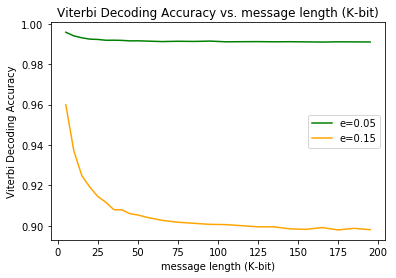

In [142]:
plt.title("Viterbi Decoding Accuracy vs. {0}".format(variable_desc["k"]))
plt.xlabel("{0}".format(variable_desc["k"]))
plt.ylabel("Viterbi Decoding Accuracy")
plt.plot(k1, acc1[0], "green", label="e=0.05")
plt.plot(k2, acc2[0], "orange", label="e=0.15")
plt.legend()

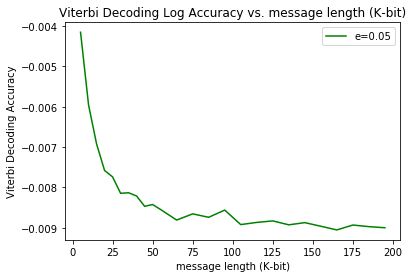

In [150]:
plt.title("Viterbi Decoding Log Accuracy vs. {0}".format(variable_desc["k"]))
plt.xlabel("{0}".format(variable_desc["k"]))
plt.ylabel("Viterbi Decoding Accuracy")
plt.plot(k1, np.log(acc1[0]), "green", label="e=0.05")
plt.legend()

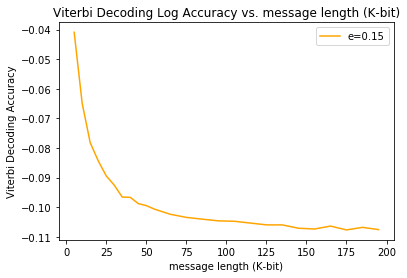

In [152]:
plt.title("Viterbi Decoding Log Accuracy vs. {0}".format(variable_desc["k"]))
plt.xlabel("{0}".format(variable_desc["k"]))
plt.ylabel("Viterbi Decoding Accuracy")
plt.plot(k2, np.log(acc2[0]), "orange", label="e=0.15")
plt.legend()

## Run 2 

In [48]:
train, test, original = build_data_from_path("../data/dataset_04/data/dataset_n25000_k10_e0.05.pkl")

In [49]:
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

In [50]:
run2_fnn_param = {
    "batch_size": 512,
    "epoch": 30,
    "verbose": 2,
    "validation_ratio": 0.2,
    "activation": "relu",
    "l2_strength": 0.0001,
    "learing_rate": 0.001,
    "optimizer": "adam",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}

In [51]:
run2_architecture = np.array([32, 64, 100]) * X_train.shape[0] // 2000

In [102]:
model = build_fnn(input_shape=X_train.shape[1:], 
                  output_shape=y_train.shape[1:], 
                  architecture=run2_architecture, 
                  param=run2_fnn_param)

In [103]:
model = train_fnn(model, X_train, y_train, 
                  param=run2_fnn_param, shuffle=True)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
 - 2s - loss: 0.6236 - acc: 0.7154 - val_loss: 0.5282 - val_acc: 0.7848
Epoch 2/30
 - 1s - loss: 0.4481 - acc: 0.8507 - val_loss: 0.3723 - val_acc: 0.8841
Epoch 3/30
 - 1s - loss: 0.3139 - acc: 0.9198 - val_loss: 0.2779 - val_acc: 0.9324
Epoch 4/30
 - 1s - loss: 0.2459 - acc: 0.9445 - val_loss: 0.2381 - val_acc: 0.9447
Epoch 5/30
 - 1s - loss: 0.2184 - acc: 0.9522 - val_loss: 0.2168 - val_acc: 0.9507
Epoch 6/30
 - 1s - loss: 0.2001 - acc: 0.9566 - val_loss: 0.2028 - val_acc: 0.9528
Epoch 7/30
 - 1s - loss: 0.1831 - acc: 0.9609 - val_loss: 0.1871 - val_acc: 0.9602
Epoch 8/30
 - 1s - loss: 0.1690 - acc: 0.9675 - val_loss: 0.1717 - val_acc: 0.9653
Epoch 9/30
 - 1s - loss: 0.1560 - acc: 0.9729 - val_loss: 0.1594 - val_acc: 0.9702
Epoch 10/30
 - 1s - loss: 0.1466 - acc: 0.9760 - val_loss: 0.1513 - val_acc: 0.9722
Epoch 11/30
 - 1s - loss: 0.1395 - acc: 0.9770 - val_loss: 0.1472 - val_acc: 0.9735
Epoch 12/30
 - 1s - loss: 0.1337 - a

In [108]:
model_accuracy(model, X_test, y_test)

0.9829199998855591

In [115]:
run2_architecture

array([ 320,  640, 1000])

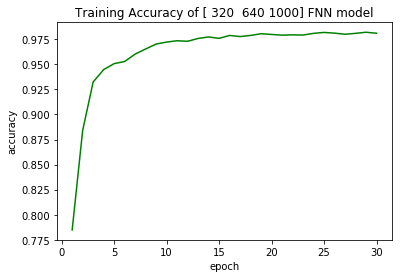

In [117]:
epoch = np.arange(1,31,1)
acc =  [0.7848, 0.8841, 0.9324, 0.9447, 0.9507, 0.9528, 0.9602, 0.9653, 0.9702, 0.9722, 0.9735,0.9730, 0.9758, 0.9773, 0.9759, 0.9788, 0.9777, 0.9788, 0.9805, 0.9798, 0.9791, 0.9794, 0.9792 ,0.9809, 0.9818, 0.9811, 0.9800, 0.9809, 0.9820, 0.981] 

plt.title("Training Accuracy of {0} FNN model".format(str(run2_architecture)))
plt.xlabel('epoch')
plt.ylabel("accuracy")
plt.plot(epoch, acc, "green")

In [118]:
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)


############## Example 0 ##############
Expected:
 [1 1 0 1 1 0 1 0 1 0]
Actual:
 [1 1 0 1 1 0 0 0 1 0]

############## Example 1 ##############
Expected:
 [0 0 1 1 1 1 1 0 0 1]
Actual:
 [0 0 1 1 1 1 1 0 0 1]

############## Example 2 ##############
Expected:
 [1 0 1 0 1 0 1 1 1 0]
Actual:
 [1 0 1 0 1 0 1 1 1 0]

############## Example 3 ##############
Expected:
 [1 1 0 0 0 1 0 1 0 0]
Actual:
 [1 1 0 0 0 0 0 1 0 0]

############## Example 4 ##############
Expected:
 [0 1 1 1 0 0 1 1 1 1]
Actual:
 [0 1 1 1 0 0 1 1 1 1]


In [126]:
# model.save("../models/v4/k10_e0.05_fnn_[{0}].h5".format(",".join(list(map(lambda x: str(x), run2_architecture)))))

In [52]:
run2_fnn_param2 = {
    "batch_size": 512,
    "epoch": 35,
    "verbose": 0,
    "validation_ratio": 0.2,
    "activation": "relu",
    "l2_strength": 0.0001,
    "learing_rate": 0.01,
    "optimizer": "adam",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}

In [144]:
FF_MODELS = [
    [32, 100],
    [64, 100],
    [128, 100],
    [256, 100],
    [32, 32, 100],
    [32, 64, 100],
    [64, 64, 100],
    [64, 128, 100],
    [128, 128, 100],
    [128, 256, 100],
    [256, 256, 100],
    [32,128,128,100],
    [32,128,256,100],
    [32,256,256,100],
    [32,128,256,128,100],
    [32,128,128,128,100],
    [1024,512,100],
    [512,256,100],
    [256,128,100],
    [128,100,100]
]

In [147]:
avg_N = 4

In [148]:
for arch in FF_MODELS:
    avg_acc = 0
    for _ in range(avg_N):
        model = build_fnn(input_shape=X_train.shape[1:], 
                          output_shape=y_train.shape[1:], 
                          architecture=arch, 
                          param=run2_fnn_param2)

        model = train_fnn(model, X_train, y_train, 
                          param=run2_fnn_param2, shuffle=True)

        avg_acc += model_accuracy(model, X_test, y_test)
        
    avg_acc /= avg_N
    print("model: {0}, acc: {1:.4f}".format(arch, avg_acc))

model: [32, 100], acc: 0.9712
model: [64, 100], acc: 0.9808
model: [128, 100], acc: 0.9819
model: [256, 100], acc: 0.9834
model: [32, 32, 100], acc: 0.9651
model: [32, 64, 100], acc: 0.9725
model: [64, 64, 100], acc: 0.9810
model: [64, 128, 100], acc: 0.9814
model: [128, 128, 100], acc: 0.9823
model: [128, 256, 100], acc: 0.9827
model: [256, 256, 100], acc: 0.9816
model: [32, 128, 128, 100], acc: 0.9725
model: [32, 128, 256, 100], acc: 0.9725
model: [32, 256, 256, 100], acc: 0.9756
model: [32, 128, 256, 128, 100], acc: 0.9516
model: [32, 128, 128, 128, 100], acc: 0.9532
model: [1024, 512, 100], acc: 0.9833
model: [512, 256, 100], acc: 0.9832
model: [256, 128, 100], acc: 0.9826
model: [128, 100, 100], acc: 0.9818


In [58]:
chosen_model_arch = [512, 256, 100]

run2_fnn_param3 = {
    "batch_size": 512,
    "epoch": 35,
    "verbose": 2,
    "validation_ratio": 0.2,
    "activation": "relu",
    "l2_strength": 0.0001,
    "learing_rate": 0.01,
    "optimizer": "adam",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}

model = build_fnn(input_shape=X_train.shape[1:], 
                  output_shape=y_train.shape[1:], 
                  architecture=chosen_model_arch, 
                  param=run2_fnn_param3)

model = train_fnn(model, X_train, y_train, 
                  param=run2_fnn_param3, shuffle=True)

Train on 16000 samples, validate on 4000 samples
Epoch 1/35
 - 1s - loss: 0.5153 - acc: 0.7170 - val_loss: 0.3798 - val_acc: 0.8035
Epoch 2/35
 - 0s - loss: 0.3005 - acc: 0.8653 - val_loss: 0.2691 - val_acc: 0.8874
Epoch 3/35
 - 0s - loss: 0.2097 - acc: 0.9305 - val_loss: 0.1661 - val_acc: 0.9594
Epoch 4/35
 - 0s - loss: 0.1394 - acc: 0.9690 - val_loss: 0.1374 - val_acc: 0.9693
Epoch 5/35
 - 0s - loss: 0.1240 - acc: 0.9741 - val_loss: 0.1274 - val_acc: 0.9731
Epoch 6/35
 - 0s - loss: 0.1113 - acc: 0.9796 - val_loss: 0.1192 - val_acc: 0.9765
Epoch 7/35
 - 0s - loss: 0.1008 - acc: 0.9829 - val_loss: 0.1097 - val_acc: 0.9790
Epoch 8/35
 - 0s - loss: 0.0993 - acc: 0.9825 - val_loss: 0.1127 - val_acc: 0.9776
Epoch 9/35
 - 0s - loss: 0.0957 - acc: 0.9838 - val_loss: 0.1046 - val_acc: 0.9804
Epoch 10/35
 - 0s - loss: 0.0930 - acc: 0.9839 - val_loss: 0.1024 - val_acc: 0.9804
Epoch 11/35
 - 0s - loss: 0.0891 - acc: 0.9848 - val_loss: 0.1033 - val_acc: 0.9796
Epoch 12/35
 - 0s - loss: 0.0889 - a

In [59]:
acc = model_accuracy(model, X_test, y_test)
print("test accuracy:", acc)

test accuracy: 0.9817600014686585


In [60]:
pred_vs_truth(model, X_test, y_test, n_show=3, y_truth_is_onehot=True)


############## Example 0 ##############
Expected:
 [0 1 1 0 1 1 0 0 0 0]
Actual:
 [0 1 1 0 1 1 0 0 0 0]

############## Example 1 ##############
Expected:
 [1 0 1 1 0 0 1 1 1 0]
Actual:
 [1 0 1 1 0 0 1 1 1 0]

############## Example 2 ##############
Expected:
 [1 0 0 0 1 1 1 1 0 1]
Actual:
 [1 0 0 0 1 1 1 1 0 1]


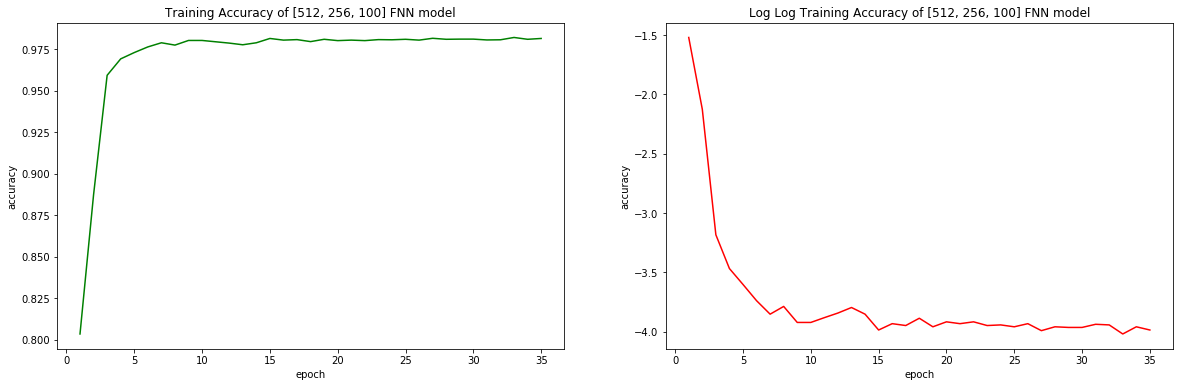

In [308]:
plot_acc("Training Accuracy of {0} FNN model".format(str(chosen_model_arch)),
         [0.8035, 0.8874, 0.9594, 0.9693, 0.9731, 0.9765, 0.9790, 0.9776, 0.9804, 0.9804, 0.9796, 0.9788, 0.9778, 0.9790, 0.9816, 0.9806, 0.9809, 0.9797, 0.9811, 0.9803, 0.9806, 0.9803, 0.9809, 0.9808, 0.9811, 0.9806, 0.9817, 0.9811, 0.9812, 0.9812, 0.9807, 0.9808, 0.9822, 0.9811, 0.9816])

## Run 3

In [237]:
run3_fnn_param = {
    "batch_size": 512,
    "epoch": 35,
    "verbose": 0,
    "validation_ratio": 0.2,
    "activation": "relu",
    "l2_strength": 0.0001,
    "learing_rate": 0.01,
    "optimizer": "adam",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}

In [245]:
avg_N = 1
run3_architecture = [256, 100]

In [43]:
ks = np.unique(list(map(lambda x: get_param_from_filename(x, "k"), data_paths)))

In [247]:
ks, data_paths = group_sort(ks, data_paths)
data_paths = data_paths[0]

In [248]:
run3_architecture[:1] + run3_architecture

[256, 256, 100]

In [249]:
fnn_accuracies = list()
viterbi_accuracies = list()
for path in data_paths:
    k = get_param_from_filename(path, "k")
    e = get_param_from_filename(path, "e")
    
    if e != 0.05:
        continue
    
    train, test, original = build_data_from_path(path)
    
    X_train, y_train = train
    X_test, y_test = test
    X, y, y_oh, y_viterbi_decoded = original
    
    # linear scaling on hidden units
    architecture = np.array(run3_architecture)
    
#     if k % 25 == 0:
#         run3_architecture = run3_architecture[:1] + run3_architecture
    
    if k > 10:
        architecture = (architecture * k // 10).astype("int")

    
    avg_acc = 0
        
    for _ in range(avg_N):
        model = build_fnn(input_shape=X_train.shape[1:], 
                          output_shape=y_train.shape[1:], 
                          architecture=architecture, 
                          param=run3_fnn_param)

        model = train_fnn(model, X_train, y_train, 
                          param=run3_fnn_param, shuffle=True)

        avg_acc += model_accuracy(model, X_test, y_test)
    
    avg_acc = avg_acc / avg_N
    viterbi_acc = accuracy(y, y_viterbi_decoded, viterbi=True)
    
    fnn_accuracies.append(avg_acc)
    viterbi_accuracies.append(viterbi_acc)
    
    print("k: {0}, model acc: {1:.4f}, viterbi acc: {2:.4f}".format(k, avg_acc, viterbi_acc))

k: 5.0, model acc: 0.9942, viterbi acc: 0.9959
k: 10.0, model acc: 0.9817, viterbi acc: 0.9941
k: 15.0, model acc: 0.9712, viterbi acc: 0.9931
k: 20.0, model acc: 0.7756, viterbi acc: 0.9925
k: 25.0, model acc: 0.6882, viterbi acc: 0.9923


KeyboardInterrupt: 

In [253]:
ks

array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        65.,  75.,  85.,  95., 105., 115., 125., 135., 145., 155., 165.,
       175., 185., 195.])

k = 5 ... 20: [512, 256, 100]


In [34]:
chosen_model_arch = (np.array([512, 256, 200]) * 10).astype("int")

run2_fnn_param3 = {
    "batch_size": 512,
    "epoch": 50,
    "verbose": 2,
    "validation_ratio": 0.2,
    "activation": "relu",
    "l2_strength": 0.0001,
    "learing_rate": 0.0001,
    "optimizer": "adam",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}
k = 145

path = "../data/dataset_04/data/dataset_n25000_k{0}_e0.05.pkl"
train, test, original = build_data_from_path(path.format(k))
    
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

model = build_fnn(input_shape=X_train.shape[1:], 
                  output_shape=y_train.shape[1:], 
                  architecture=chosen_model_arch, 
                  param=run2_fnn_param3)

model = train_fnn(model, X_train, y_train, 
                  param=run2_fnn_param3, shuffle=True)

Train on 16000 samples, validate on 4000 samples
Epoch 1/50
 - 94s - loss: 2.1536 - acc: 0.5024 - val_loss: 1.9388 - val_acc: 0.5051
Epoch 2/50


KeyboardInterrupt: 

In [283]:
acc = model_accuracy(model, X_test, y_test)
print("test accuracy:", acc)
pred_vs_truth(model, X_test, y_test, n_show=3, y_truth_is_onehot=True)

test accuracy: 0.9112900004386902

############## Example 0 ##############
Expected:
 [1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1
 1 0 0]
Actual:
 [1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 0 1
 1 0 0]

############## Example 1 ##############
Expected:
 [0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1
 1 0 1]
Actual:
 [0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1
 1 0 1]

############## Example 2 ##############
Expected:
 [0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1
 0 0 0]
Actual:
 [0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1
 0 0 0]


In [ ]:
# plt.title("Accuracy vs. {0}".format(variable_desc["k"]))

# plt.xlabel("{0}".format(variable_desc["k"]))
# plt.ylabel("Decoding Accuracy")

# plt.plot(ks, viterbi_accuracies, "green", label="Viterbi Decoding")
# plt.plot(ks, fnn_accuracies, "orange", label="FNN Model")

# plt.legend()

## Run 4

In [129]:
print(np.sort(ks))

[  5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  65.  75.  85.
  95. 105. 115. 125. 135. 145. 155. 165. 175. 185. 195.]


In [ ]:
run4_cnn_param = {
    "batch_size": 512,
    "epoch": 20,
    "verbose": 2,
    "validation_ratio": 0.2,
    "activation": "relu",
    "dropout_keep_prob": 0.5,
    "learing_rate": 0.005,
    "optimizer": "adam",
    "conv_padding": "same",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}

In [270]:
run4_cnn_architecture = [
    ("conv1d", dict(f=60,k=3,s=1)),
    ("conv1d", dict(f=60,k=3,s=1)),
    ("conv1d", dict(f=60,k=3,s=1)),
    ("conv1d", dict(f=60,k=3,s=1)),
    ("flatten", None),
    ("dense", 512),
    ("dropout", None),
    ("dense", 256)
]

In [271]:
load(path.format(20))[0].shape

(25000, 44)

In [272]:
k = 20
path = "../data/dataset_04/data/dataset_n25000_k{0}_e0.05.pkl"
train, test, original = build_data_from_path(path.format(k), X_reshape=(-1, 11, 4))
    
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

In [273]:
model = build_cnn(input_shape=X_train.shape[1:], 
                  output_shape=y_train.shape[1:], 
                  architecture=run4_cnn_architecture, 
                  param=run4_cnn_param)

In [274]:
model = train_cnn(model, X_train, y_train, 
                  param=run4_cnn_param, shuffle=True)

Train on 16000 samples, validate on 4000 samples
Epoch 1/35
 - 4s - loss: 0.6038 - acc: 0.6132 - val_loss: 0.3985 - val_acc: 0.8160
Epoch 2/35
 - 2s - loss: 0.2673 - acc: 0.8889 - val_loss: 0.1226 - val_acc: 0.9547
Epoch 3/35
 - 2s - loss: 0.1471 - acc: 0.9456 - val_loss: 0.0920 - val_acc: 0.9670
Epoch 4/35
 - 1s - loss: 0.1151 - acc: 0.9585 - val_loss: 0.0786 - val_acc: 0.9721
Epoch 5/35
 - 1s - loss: 0.0991 - acc: 0.9643 - val_loss: 0.0724 - val_acc: 0.9741
Epoch 6/35
 - 2s - loss: 0.0883 - acc: 0.9682 - val_loss: 0.0651 - val_acc: 0.9769
Epoch 7/35
 - 2s - loss: 0.0781 - acc: 0.9719 - val_loss: 0.0627 - val_acc: 0.9779
Epoch 8/35
 - 1s - loss: 0.0712 - acc: 0.9745 - val_loss: 0.0586 - val_acc: 0.9791
Epoch 9/35
 - 2s - loss: 0.0670 - acc: 0.9761 - val_loss: 0.0582 - val_acc: 0.9800
Epoch 10/35
 - 2s - loss: 0.0608 - acc: 0.9782 - val_loss: 0.0558 - val_acc: 0.9807
Epoch 11/35
 - 2s - loss: 0.0556 - acc: 0.9801 - val_loss: 0.0560 - val_acc: 0.9814
Epoch 12/35
 - 2s - loss: 0.0518 - a

KeyboardInterrupt: 

In [275]:
model_accuracy(model, X_test, y_test)

0.9840500002861023

In [276]:
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)


############## Example 0 ##############
Expected:
 [0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1]
Actual:
 [0 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1]

############## Example 1 ##############
Expected:
 [0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 1]
Actual:
 [0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 1]

############## Example 2 ##############
Expected:
 [0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1]
Actual:
 [0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1]

############## Example 3 ##############
Expected:
 [0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1]
Actual:
 [0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1]

############## Example 4 ##############
Expected:
 [1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0]
Actual:
 [1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0]


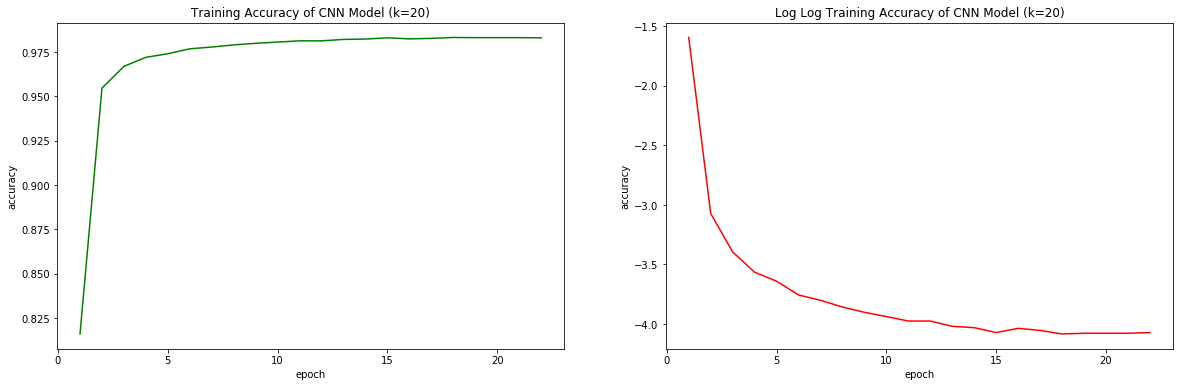

In [311]:
plot_acc("Training Accuracy of CNN Model (k=20)",
         [0.8160, 0.9547, 0.9670, 0.9721, 0.9741, 0.9769, 0.9779, 0.9791, 0.9800, 0.9807, 0.9814, 0.9814, 0.9822, 0.9824, 0.9831, 0.9825, 0.9828, 0.9833, 0.9832, 0.9832, 0.9832, 0.9831])

In [277]:
run4_cnn_architecture = [
    ("conv1d", dict(f=120,k=3,s=1)),
    ("conv1d", dict(f=120,k=3,s=1)),
    ("conv1d", dict(f=120,k=3,s=1)),
    ("conv1d", dict(f=120,k=3,s=1)),
    ("flatten", None),
    ("dense", 512),
    ("dropout", None),
    ("dense", 256)
]

In [278]:
load(path.format(40))[0].shape

(25000, 84)

In [280]:
k = 40
path = "../data/dataset_04/data/dataset_n25000_k{0}_e0.05.pkl"
train, test, original = build_data_from_path(path.format(k), X_reshape=(-1, 28, 3))
    
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original
model = build_cnn(input_shape=X_train.shape[1:], 
                  output_shape=y_train.shape[1:], 
                  architecture=run4_cnn_architecture, 
                  param=run4_cnn_param)
model = train_cnn(model, X_train, y_train, 
                  param=run4_cnn_param, shuffle=True)

Train on 16000 samples, validate on 4000 samples
Epoch 1/35
 - 8s - loss: 0.6801 - acc: 0.5251 - val_loss: 0.6276 - val_acc: 0.5975
Epoch 2/35
 - 6s - loss: 0.5262 - acc: 0.7127 - val_loss: 0.3055 - val_acc: 0.8808
Epoch 3/35
 - 7s - loss: 0.3069 - acc: 0.8700 - val_loss: 0.1441 - val_acc: 0.9528
Epoch 4/35
 - 6s - loss: 0.2385 - acc: 0.9037 - val_loss: 0.1105 - val_acc: 0.9644
Epoch 5/35
 - 6s - loss: 0.2136 - acc: 0.9149 - val_loss: 0.1096 - val_acc: 0.9656
Epoch 6/35
 - 6s - loss: 0.1971 - acc: 0.9227 - val_loss: 0.0908 - val_acc: 0.9722
Epoch 7/35
 - 7s - loss: 0.1842 - acc: 0.9282 - val_loss: 0.0858 - val_acc: 0.9731
Epoch 8/35
 - 6s - loss: 0.1766 - acc: 0.9316 - val_loss: 0.0821 - val_acc: 0.9742
Epoch 9/35
 - 6s - loss: 0.1689 - acc: 0.9345 - val_loss: 0.0771 - val_acc: 0.9757
Epoch 10/35
 - 7s - loss: 0.1621 - acc: 0.9374 - val_loss: 0.0737 - val_acc: 0.9768
Epoch 11/35
 - 10s - loss: 0.1587 - acc: 0.9386 - val_loss: 0.0740 - val_acc: 0.9769
Epoch 12/35
 - 7s - loss: 0.1546 - 

KeyboardInterrupt: 

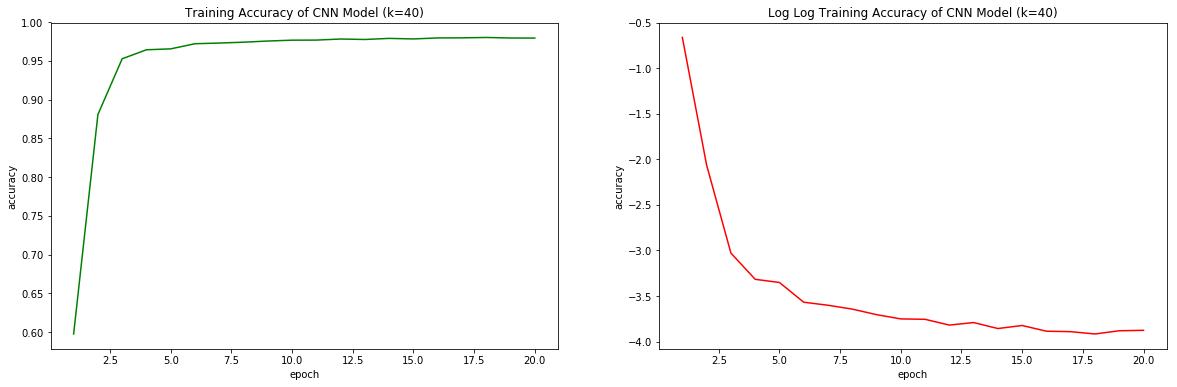

In [310]:
plot_acc("Training Accuracy of CNN Model (k=40)",
       [0.5975,0.8808,0.9528,0.9644,0.9656,0.9722,0.9731,0.9742,0.9757,0.9768,0.9769,0.9783,0.9777,0.9791,0.9784,0.9797,0.9798,0.9803,0.9796,0.9795])

In [286]:
print(model_accuracy(model, X_test, y_test))
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)

0.9806124991416931

############## Example 0 ##############
Expected:
 [0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1
 0 0 1]
Actual:
 [0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1
 0 0 1]

############## Example 1 ##############
Expected:
 [1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1
 0 1 1]
Actual:
 [1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1
 0 1 1]

############## Example 2 ##############
Expected:
 [0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0
 0 0 1]
Actual:
 [0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0
 0 0 1]

############## Example 3 ##############
Expected:
 [1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0
 0 1 0]
Actual:
 [1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0
 0 1 0]

############## Example 4 ##############
Expected:
 [0 0 1 1 1 1 0 1 0 1 

In [366]:
run4_cnn_param = {
    "batch_size": 256,
    "epoch": 20,
    "verbose": 2,
    "validation_ratio": 0.2,
    "activation": "relu",
    "dropout_keep_prob": 0.5,
    "learing_rate": 0.005,
    "optimizer": "adam",
    "conv_padding": "same",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}

In [369]:
run4_cnn_architecture = [
    ("conv1d", dict(f=300,k=3,s=1)),
    ("conv1d", dict(f=300,k=3,s=1)),
    ("conv1d", dict(f=300,k=3,s=1)),
    ("conv1d", dict(f=300,k=3,s=1)),
    ("flatten", None),
    ("dense", 512),
    ("dropout", None),
    ("dense", 256)
]

In [370]:
k = 105
path = "../data/dataset_04/data/dataset_n25000_k{0}_e0.05.pkl"
train, test, original = build_data_from_path(path.format(k), X_reshape=(-1,71,3))
    
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

model = build_cnn(input_shape=X_train.shape[1:], 
                  output_shape=y_train.shape[1:], 
                  architecture=run4_cnn_architecture, 
                  param=run4_cnn_param)
model = train_cnn(model, X_train, y_train, 
                  param=run4_cnn_param, shuffle=True)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 90s - loss: 0.7149 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5011
Epoch 2/20
 - 83s - loss: 0.6931 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.5015
Epoch 3/20
 - 85s - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6932 - val_acc: 0.5012
Epoch 4/20


KeyboardInterrupt: 

In [ ]:
# print(model_accuracy(model, X_test, y_test))
# pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)

In [400]:
run4_cnn_param = {
    "batch_size": 512,
    "epoch": 30,
    "verbose": 2,
    "validation_ratio": 0.2,
    "activation": "relu",
    "dropout_keep_prob": 0.5,
    "learing_rate": 0.0005,
    "optimizer": "adam",
    "conv_padding": "same",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}
run4_cnn_architecture = [
    ("conv1d", dict(f=120,k=3,s=1)),
    ("conv1d", dict(f=120,k=3,s=1)),
    ("conv1d", dict(f=120,k=3,s=1)),
    ("conv1d", dict(f=120,k=3,s=1)),
    ("flatten", None),
    ("dense", 512),
    ("dropout", None),
    ("dense", 256)
]

In [401]:
k = 20
path = "../data/dataset_04/data/dataset_n25000_k{0}_e0.15.pkl"
train, test, original = build_data_from_path(path.format(k), X_reshape=(-1, 14, 3))
    
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

In [402]:
model = build_cnn(input_shape=X_train.shape[1:], 
                  output_shape=y_train.shape[1:], 
                  architecture=run4_cnn_architecture, 
                  param=run4_cnn_param)
model = train_cnn(model, X_train, y_train, 
                  param=run4_cnn_param, shuffle=True)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
 - 7s - loss: 0.6864 - acc: 0.5286 - val_loss: 0.6563 - val_acc: 0.5700
Epoch 2/30
 - 4s - loss: 0.6233 - acc: 0.6136 - val_loss: 0.5579 - val_acc: 0.6813
Epoch 3/30
 - 3s - loss: 0.5475 - acc: 0.6890 - val_loss: 0.5040 - val_acc: 0.7132
Epoch 4/30
 - 4s - loss: 0.5079 - acc: 0.7121 - val_loss: 0.4783 - val_acc: 0.7246
Epoch 5/30
 - 4s - loss: 0.4878 - acc: 0.7237 - val_loss: 0.4703 - val_acc: 0.7322
Epoch 6/30
 - 3s - loss: 0.4738 - acc: 0.7327 - val_loss: 0.4560 - val_acc: 0.7397
Epoch 7/30
 - 3s - loss: 0.4618 - acc: 0.7397 - val_loss: 0.4486 - val_acc: 0.7435
Epoch 8/30
 - 4s - loss: 0.4521 - acc: 0.7458 - val_loss: 0.4409 - val_acc: 0.7485
Epoch 9/30
 - 4s - loss: 0.4439 - acc: 0.7509 - val_loss: 0.4362 - val_acc: 0.7505
Epoch 10/30
 - 3s - loss: 0.4363 - acc: 0.7557 - val_loss: 0.4334 - val_acc: 0.7512
Epoch 11/30
 - 3s - loss: 0.4315 - acc: 0.7575 - val_loss: 0.4301 - val_acc: 0.7532
Epoch 12/30
 - 4s - loss: 0.4258 - a

In [403]:
print(model_accuracy(model, X_test, y_test))
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)

0.7582049993515014

############## Example 0 ##############
Expected:
 [0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 0]
Actual:
 [0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1]

############## Example 1 ##############
Expected:
 [0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0]
Actual:
 [0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 0]

############## Example 2 ##############
Expected:
 [0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1]
Actual:
 [0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1]

############## Example 3 ##############
Expected:
 [1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1]
Actual:
 [1 1 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0]

############## Example 4 ##############
Expected:
 [0 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1]
Actual:
 [0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0]


## LSTM

### k10, e0.05

In [34]:
train, test, original = build_data_from_path("../data/dataset_04/data/dataset_n25000_k10_e0.05.pkl")

In [35]:
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

In [40]:
print(X_train.shape)
print(y_train.shape)

(20000, 24)
(20000, 10, 2)


In [139]:
lr = 0.01

In [140]:
model = Sequential()

model.add(Embedding(2, 10))
model.add(Dropout(0.5))

model.add(LSTM(100, activation="tanh", input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(200, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

In [141]:
history = model.fit(X_train, y_train, epochs=35, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/35
 - 6s - loss: 0.6410 - acc: 0.5657 - val_loss: 0.5772 - val_acc: 0.6222
Epoch 2/35
 - 4s - loss: 0.5739 - acc: 0.6359 - val_loss: 0.5124 - val_acc: 0.7065
Epoch 3/35
 - 4s - loss: 0.5070 - acc: 0.7123 - val_loss: 0.4341 - val_acc: 0.7679
Epoch 4/35
 - 3s - loss: 0.4388 - acc: 0.7637 - val_loss: 0.3769 - val_acc: 0.7918
Epoch 5/35
 - 3s - loss: 0.3995 - acc: 0.7926 - val_loss: 0.3186 - val_acc: 0.8427
Epoch 6/35
 - 4s - loss: 0.3582 - acc: 0.8190 - val_loss: 0.2799 - val_acc: 0.8657
Epoch 7/35
 - 3s - loss: 0.3256 - acc: 0.8402 - val_loss: 0.2466 - val_acc: 0.8911
Epoch 8/35
 - 4s - loss: 0.2987 - acc: 0.8577 - val_loss: 0.2266 - val_acc: 0.9042
Epoch 9/35
 - 4s - loss: 0.2724 - acc: 0.8756 - val_loss: 0.1881 - val_acc: 0.9252
Epoch 10/35
 - 4s - loss: 0.2440 - acc: 0.8934 - val_loss: 0.1582 - val_acc: 0.9392
Epoch 11/35
 - 3s - loss: 0.2245 - acc: 0.9045 - val_loss: 0.1402 - val_acc: 0.9486
Epoch 12/35
 - 4s - loss: 0.2046 - a

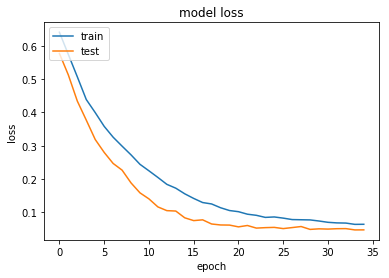

In [142]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [143]:
print(model_accuracy(model, X, y, argmax=True))
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)

0.987132

############## Example 0 ##############
Expected:
 [0 1 1 0 1 0 0 0 0 1]
Actual:
 [0 1 1 0 1 0 0 0 0 1]

############## Example 1 ##############
Expected:
 [0 1 1 1 1 0 1 1 0 1]
Actual:
 [0 1 1 1 1 0 1 1 0 1]

############## Example 2 ##############
Expected:
 [0 0 1 0 0 0 1 1 1 1]
Actual:
 [0 0 1 0 0 0 1 1 1 1]

############## Example 3 ##############
Expected:
 [0 1 0 1 1 1 0 1 1 0]
Actual:
 [0 1 0 1 1 1 0 1 1 0]

############## Example 4 ##############
Expected:
 [0 0 0 0 1 1 1 0 1 0]
Actual:
 [0 0 0 0 1 1 1 0 1 0]


### k10 e0.15

Train on 16000 samples, validate on 4000 samples
Epoch 1/35
 - 14s - loss: 0.6652 - acc: 0.5431 - val_loss: 0.6217 - val_acc: 0.5869
Epoch 2/35
 - 11s - loss: 0.6194 - acc: 0.5871 - val_loss: 0.5945 - val_acc: 0.6084
Epoch 3/35
 - 11s - loss: 0.5992 - acc: 0.6060 - val_loss: 0.5742 - val_acc: 0.6238
Epoch 4/35
 - 11s - loss: 0.5827 - acc: 0.6203 - val_loss: 0.5626 - val_acc: 0.6373
Epoch 5/35
 - 10s - loss: 0.5732 - acc: 0.6343 - val_loss: 0.5476 - val_acc: 0.6497
Epoch 6/35
 - 11s - loss: 0.5609 - acc: 0.6493 - val_loss: 0.5333 - val_acc: 0.6718
Epoch 7/35
 - 12s - loss: 0.5484 - acc: 0.6652 - val_loss: 0.5178 - val_acc: 0.6882
Epoch 8/35
 - 10s - loss: 0.5345 - acc: 0.6829 - val_loss: 0.5031 - val_acc: 0.7065
Epoch 9/35
 - 10s - loss: 0.5149 - acc: 0.7060 - val_loss: 0.4835 - val_acc: 0.7352
Epoch 10/35
 - 11s - loss: 0.4936 - acc: 0.7291 - val_loss: 0.4593 - val_acc: 0.7494
Epoch 11/35
 - 10s - loss: 0.4692 - acc: 0.7442 - val_loss: 0.4250 - val_acc: 0.7701
Epoch 12/35
 - 10s - loss

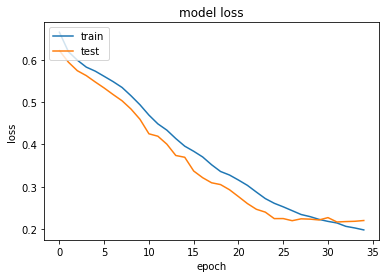

0.930448

############## Example 0 ##############
Expected:
 [1 0 0 1 1 1 1 1 0 1]
Actual:
 [1 0 0 1 1 1 1 1 0 1]

############## Example 1 ##############
Expected:
 [1 1 1 1 0 0 0 0 1 0]
Actual:
 [1 1 1 1 0 0 0 0 1 0]

############## Example 2 ##############
Expected:
 [1 1 0 1 1 0 1 1 1 1]
Actual:
 [0 1 0 1 1 0 1 1 1 1]

############## Example 3 ##############
Expected:
 [1 0 1 0 1 1 1 0 0 1]
Actual:
 [1 0 1 0 0 1 0 1 0 1]

############## Example 4 ##############
Expected:
 [1 0 0 0 1 0 0 0 0 1]
Actual:
 [1 0 0 0 1 0 0 0 0 1]


In [147]:
train, test, original = build_data_from_path("../data/dataset_04/data/dataset_n25000_k10_e0.15.pkl")
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

lr = 0.005
model = Sequential()

model.add(Embedding(2, 10))
model.add(Dropout(0.5))

model.add(LSTM(200, activation="tanh", input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(200, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=35, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(model_accuracy(model, X, y, argmax=True))
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)

### k20 e0.05

Train on 16000 samples, validate on 4000 samples
Epoch 1/35
 - 18s - loss: 0.6638 - acc: 0.5357 - val_loss: 0.6737 - val_acc: 0.5562
Epoch 2/35
 - 14s - loss: 0.6412 - acc: 0.5554 - val_loss: 0.6147 - val_acc: 0.5696
Epoch 3/35
 - 14s - loss: 0.6164 - acc: 0.5747 - val_loss: 0.5942 - val_acc: 0.5922
Epoch 4/35
 - 15s - loss: 0.5946 - acc: 0.5969 - val_loss: 0.5688 - val_acc: 0.6182
Epoch 5/35
 - 13s - loss: 0.5714 - acc: 0.6278 - val_loss: 0.5406 - val_acc: 0.6569
Epoch 6/35
 - 12s - loss: 0.5460 - acc: 0.6619 - val_loss: 0.5081 - val_acc: 0.6917
Epoch 7/35
 - 12s - loss: 0.5249 - acc: 0.6849 - val_loss: 0.4799 - val_acc: 0.7204
Epoch 8/35
 - 12s - loss: 0.4983 - acc: 0.7095 - val_loss: 0.4565 - val_acc: 0.7373
Epoch 9/35
 - 13s - loss: 0.4793 - acc: 0.7265 - val_loss: 0.4374 - val_acc: 0.7574
Epoch 10/35
 - 13s - loss: 0.4555 - acc: 0.7471 - val_loss: 0.4058 - val_acc: 0.7797
Epoch 11/35
 - 12s - loss: 0.4371 - acc: 0.7648 - val_loss: 0.3914 - val_acc: 0.7927
Epoch 12/35
 - 13s - loss

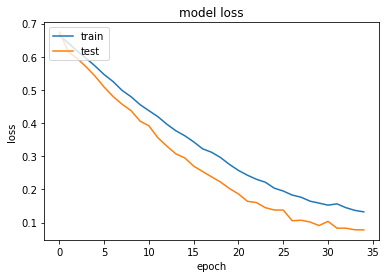

0.978276

############## Example 0 ##############
Expected:
 [1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1]
Actual:
 [1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1]

############## Example 1 ##############
Expected:
 [0 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1]
Actual:
 [0 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1]

############## Example 2 ##############
Expected:
 [1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0]
Actual:
 [1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0]

############## Example 3 ##############
Expected:
 [1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0]
Actual:
 [1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0]

############## Example 4 ##############
Expected:
 [1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0]
Actual:
 [1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0]


In [148]:
train, test, original = build_data_from_path("../data/dataset_04/data/dataset_n25000_k20_e0.05.pkl")
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

lr = 0.01
model = Sequential()

model.add(Embedding(2, 20))
model.add(Dropout(0.5))

model.add(LSTM(200, activation="tanh", input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(400, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(40, activation="sigmoid"))
model.add(Reshape((20,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=35, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(model_accuracy(model, X, y, argmax=True))
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)

Train on 16000 samples, validate on 4000 samples
Epoch 1/40
 - 18s - loss: 0.6700 - acc: 0.5307 - val_loss: 0.6435 - val_acc: 0.5507
Epoch 2/40
 - 17s - loss: 0.6382 - acc: 0.5616 - val_loss: 0.6154 - val_acc: 0.5890
Epoch 3/40
 - 19s - loss: 0.6071 - acc: 0.6101 - val_loss: 0.5682 - val_acc: 0.6543
Epoch 4/40
 - 16s - loss: 0.5713 - acc: 0.6551 - val_loss: 0.5262 - val_acc: 0.6989
Epoch 5/40
 - 14s - loss: 0.5399 - acc: 0.6898 - val_loss: 0.4919 - val_acc: 0.7273
Epoch 6/40
 - 13s - loss: 0.5136 - acc: 0.7151 - val_loss: 0.4767 - val_acc: 0.7458
Epoch 7/40
 - 12s - loss: 0.4942 - acc: 0.7311 - val_loss: 0.4498 - val_acc: 0.7594
Epoch 8/40
 - 12s - loss: 0.4742 - acc: 0.7469 - val_loss: 0.4238 - val_acc: 0.7829
Epoch 9/40
 - 13s - loss: 0.4525 - acc: 0.7635 - val_loss: 0.4054 - val_acc: 0.7897
Epoch 10/40
 - 12s - loss: 0.4385 - acc: 0.7725 - val_loss: 0.3856 - val_acc: 0.8019
Epoch 11/40
 - 12s - loss: 0.4184 - acc: 0.7862 - val_loss: 0.3633 - val_acc: 0.8177
Epoch 12/40
 - 12s - loss

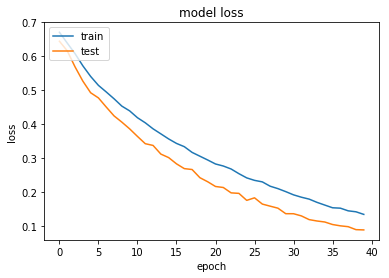

0.975926

############## Example 0 ##############
Expected:
 [1 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 1]
Actual:
 [1 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 1]

############## Example 1 ##############
Expected:
 [0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0]
Actual:
 [0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0]

############## Example 2 ##############
Expected:
 [1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0]
Actual:
 [1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0]

############## Example 3 ##############
Expected:
 [0 1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0]
Actual:
 [1 1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0]

############## Example 4 ##############
Expected:
 [1 1 1 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1]
Actual:
 [1 1 1 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 1 1]


In [153]:
train, test, original = build_data_from_path("../data/dataset_04/data/dataset_n25000_k20_e0.05.pkl")
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

lr = 0.005
model = Sequential()

model.add(Embedding(2, 20))
model.add(Dropout(0.5))

model.add(LSTM(200, activation="tanh", input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(400, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(40, activation="sigmoid"))
model.add(Reshape((20,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=40, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(model_accuracy(model, X, y, argmax=True))
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)

In [154]:
history = model.fit(X_train, y_train, epochs=40, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/40
 - 13s - loss: 0.1288 - acc: 0.9497 - val_loss: 0.0831 - val_acc: 0.9736
Epoch 2/40
 - 13s - loss: 0.1218 - acc: 0.9528 - val_loss: 0.0789 - val_acc: 0.9747
Epoch 3/40
 - 13s - loss: 0.1174 - acc: 0.9548 - val_loss: 0.0766 - val_acc: 0.9751
Epoch 4/40
 - 15s - loss: 0.1167 - acc: 0.9553 - val_loss: 0.0757 - val_acc: 0.9759
Epoch 5/40
 - 17s - loss: 0.1124 - acc: 0.9574 - val_loss: 0.0746 - val_acc: 0.9761
Epoch 6/40
 - 16s - loss: 0.1108 - acc: 0.9583 - val_loss: 0.0723 - val_acc: 0.9772
Epoch 7/40
 - 16s - loss: 0.1060 - acc: 0.9605 - val_loss: 0.0768 - val_acc: 0.9746
Epoch 8/40
 - 16s - loss: 0.1045 - acc: 0.9611 - val_loss: 0.0727 - val_acc: 0.9783
Epoch 9/40
 - 15s - loss: 0.0986 - acc: 0.9633 - val_loss: 0.0716 - val_acc: 0.9797
Epoch 10/40
 - 16s - loss: 0.0950 - acc: 0.9649 - val_loss: 0.0713 - val_acc: 0.9779
Epoch 11/40
 - 16s - loss: 0.0951 - acc: 0.9651 - val_loss: 0.0713 - val_acc: 0.9788
Epoch 12/40
 - 14s - loss

KeyboardInterrupt: 

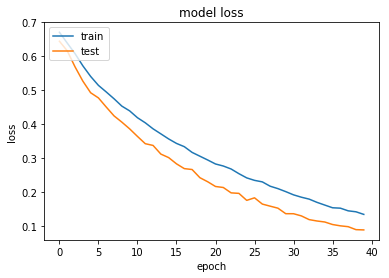

0.985642

############## Example 0 ##############
Expected:
 [0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1]
Actual:
 [0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1]

############## Example 1 ##############
Expected:
 [1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1]
Actual:
 [1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1]

############## Example 2 ##############
Expected:
 [0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0]
Actual:
 [0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0]

############## Example 3 ##############
Expected:
 [1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1]
Actual:
 [1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1]

############## Example 4 ##############
Expected:
 [0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1]
Actual:
 [0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1]


In [155]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(model_accuracy(model, X, y, argmax=True))
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)

### k20 e0.15

Train on 16000 samples, validate on 4000 samples
Epoch 1/40
 - 24s - loss: 0.6703 - acc: 0.5312 - val_loss: 0.6494 - val_acc: 0.5467
Epoch 2/40
 - 22s - loss: 0.6477 - acc: 0.5517 - val_loss: 0.6419 - val_acc: 0.5540
Epoch 3/40
 - 23s - loss: 0.6393 - acc: 0.5583 - val_loss: 0.6295 - val_acc: 0.5638
Epoch 4/40
 - 21s - loss: 0.6322 - acc: 0.5665 - val_loss: 0.6239 - val_acc: 0.5696
Epoch 5/40
 - 22s - loss: 0.6272 - acc: 0.5713 - val_loss: 0.6174 - val_acc: 0.5765
Epoch 6/40
 - 23s - loss: 0.6222 - acc: 0.5763 - val_loss: 0.6097 - val_acc: 0.5829
Epoch 7/40
 - 24s - loss: 0.6171 - acc: 0.5823 - val_loss: 0.6082 - val_acc: 0.5854
Epoch 8/40
 - 26s - loss: 0.6133 - acc: 0.5888 - val_loss: 0.6047 - val_acc: 0.5910
Epoch 9/40
 - 25s - loss: 0.6080 - acc: 0.5937 - val_loss: 0.5980 - val_acc: 0.5968
Epoch 10/40
 - 24s - loss: 0.6039 - acc: 0.5980 - val_loss: 0.5968 - val_acc: 0.5999
Epoch 11/40
 - 22s - loss: 0.6021 - acc: 0.6017 - val_loss: 0.5937 - val_acc: 0.6046
Epoch 12/40
 - 20s - loss

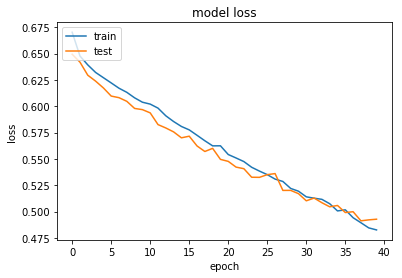

0.7302

############## Example 0 ##############
Expected:
 [0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0]
Actual:
 [1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 0]

############## Example 1 ##############
Expected:
 [0 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1]
Actual:
 [1 1 1 0 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1]

############## Example 2 ##############
Expected:
 [0 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 1 0 1 0]
Actual:
 [1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0]

############## Example 3 ##############
Expected:
 [0 0 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 0]
Actual:
 [1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0 0]

############## Example 4 ##############
Expected:
 [1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1]
Actual:
 [1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 1 0]


In [162]:
train, test, original = build_data_from_path("../data/dataset_04/data/dataset_n25000_k20_e0.15.pkl")
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

lr = 0.01
model = Sequential()

model.add(Embedding(2, 40))
model.add(Dropout(0.5))

model.add(LSTM(200, activation="tanh", input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(400, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(40, activation="sigmoid"))
model.add(Reshape((20,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=40, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(model_accuracy(model, X, y, argmax=True))
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)

### k40 e0.05

In [151]:
train, test, original = build_data_from_path("../data/dataset_04/data/dataset_n25000_k40_e0.05.pkl")
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

lr = 0.01
model = Sequential()

model.add(Embedding(2, 30))
model.add(Dropout(0.5))

model.add(LSTM(300, activation="tanh", input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(600, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(80, activation="sigmoid"))
model.add(Reshape((40,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=35, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(model_accuracy(model, X, y, argmax=True))
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)

Train on 16000 samples, validate on 4000 samples
Epoch 1/35
 - 61s - loss: 0.6790 - acc: 0.5189 - val_loss: 0.6630 - val_acc: 0.5297
Epoch 2/35
 - 61s - loss: 0.6594 - acc: 0.5353 - val_loss: 0.6475 - val_acc: 0.5413
Epoch 3/35
 - 51s - loss: 0.6467 - acc: 0.5481 - val_loss: 0.6360 - val_acc: 0.5550
Epoch 4/35
 - 50s - loss: 0.6370 - acc: 0.5595 - val_loss: 0.6220 - val_acc: 0.5697
Epoch 5/35


KeyboardInterrupt: 